<a href="https://colab.research.google.com/github/halvarsu/MLSummerSchoolVienna2022/blob/add_solutions/Day04_July14/ML_for_Materials_Hard_and_Soft_ML_for_Ab_initio_Electronic_Structure_Tutorial_(Solution).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning for _Ab-initio_ Electronic Structure Tutorial

This tutorial is for the [ML for Materials Hard and Soft](https://physik.univie.ac.at/events/events-detailansicht/news/machine-learning-for-materials-hard-and-soft-esi-dcafm-taco-vdsp-summer-school-2022/) summer school at the University of Vienna in July 2022.

This version of the colab contains solutions. A problems-only version can be found [here](https://colab.research.google.com/github/CompPhysVienna/MLSummerSchoolVienna2022/blob/main/Day04_July14/ML_for_Materials_Hard_and_Soft_ML_for_Ab_initio_Electronic_Structure_Tutorial.ipynb).

© The Authors. Apache License 2.0.

Halvard Sutterud (Imperial College London)

David Pfau, James Spencer (DeepMind)

# Outline

In this tutorial, we hope to give you an introduction for how to implement a neural network wavefunction ansatz in JAX. We'll give a very short introduction to JAX, then walk you through how to create a simple neural network, evaluate the energy and gradient of the energy for simple systems, how to sample from the wavefunction squared, and finally how to train the neural network by variational Monte Carlo.

# Imports

The main package we will be using is [JAX](https://jax.readthedocs.io/), a library for automatic differentiation on advanced hardware (like GPUs and TPUs) which is closely modeled on NumPy and SciPy. While JAX is ideal for working with this advanced hardware, nothing in this tutorial requires anything more than a standard CPU backend. JAX, NumPy and many other packages come installed by default in Colab. For this tutorial we'll use [Optax](https://optax.readthedocs.io/) so that we don't have to write optimizers like ADAM by hand. We also will be using [PySCF](https://pyscf.org/) to run reference calculations using more traditional electronic structure methods, and [PyBlock](https://pyblock.readthedocs.io/) to analyze the results.

To run the code in these cells, just hit `shift`+`enter`. Then JAX should import without issue.

In [ ]:
!pip install optax > /dev/null 2>&1  # optax is a library for optimization based on jax
!pip install pyscf > /dev/null 2>&1  # pyscf is for calculating reference energies
!pip install pyblock > /dev/null 2>&1  # pyblock is for error analysis

import jax
jax.__version__

'0.3.14'

# JAX Introduction

This whirlwhind tour through JAX will hopefully be enough to get started on the problems in the rest of this tutorial. The JAX documentation itself has many fantastic additional resources for learning about the ins and outs of the package:

https://jax.readthedocs.io/en/latest/jax-101/index.html

https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html

https://jax.readthedocs.io/en/latest/notebooks/Custom_derivative_rules_for_Python_code.html

Most standard numerical operations in JAX can be found in the `jax.numpy` directory. This is a 1:1 implementation of the NumPy interface. In a few cases, there are extra arguments in the JAX implementation, but everything that exists in NumPy should also exist in `jax.numpy` (though there are a very small number of edge cases that should fail with a warning). There is also a `jax.scipy` directory which contains implementations of many special functions in SciPy, though it is not as complete as `jax.numpy`. There are also several special linear algebra operations not available in either which can be found in `jax.lax` , but we will not need those in this tutorial.

In [ ]:
import jax.numpy as jnp  # the standard abbreviation, to avoid confusion with numpy
import numpy as np

## Creating Arrays

Arrays work basically the same...

In [ ]:
x_np = np.array([1, 2, 3])
x_jax = jnp.array([1, 2, 3])

print(x_np)
print(x_jax)

[1 2 3]
[1 2 3]


...but have different types

In [ ]:
print(type(x_np))
print(type(x_jax))

<class 'numpy.ndarray'>
<class 'jaxlib.xla_extension.DeviceArray'>


## Functions

Functions written in NumPy can often be replaced line-for-line with JAX

In [ ]:
def f_np(x):
  y = 2 * x
  z = x + 1
  return jnp.dot(np.log(y), z)

def f_jax(x):
  y = 2 * x
  z = x + 1
  return jnp.dot(jnp.log(y), z)

In [ ]:
print(f_np(x_np))
print(f_jax(x_jax))

12.712215
12.712215


Note that the results are not _quite_ the same, because JAX is float32 by default while NumPy is float64. float64 can be enabled before any computation is executed, but is not necessary here.

JAX is also clever enough that it can take NumPy arrays as input and convert them to JAX arrays, and vice-versa (though this can often become confusing and lead to errors when using more advanced JAX features)

In [ ]:
print(f_jax(x_np))
print(f_np(x_jax))

12.712215
12.712215


## Immutable Arrays

One difference from NumPy and other numerical packages is that JAX is *stateless*. Given the same inputs, a JAX function is guaranteed to produce the same outputs (modulo some nondeterminism for certain operations on GPUs). This enables JAX to analyze the structure of these functions and make program transformations that are guaranteed to be correct.

This statelessness extends to arrays - in-place operations are *not* allowed on JAX arrays. Instead, there is semantic sugar for creating a new array which is identical up to the indices to be updated. While this may seem inefficient, when combined with just-in-time compilation, the compiler is clever enough to turn these into in-place operations when appropriate.

In [ ]:
# In-place operations are fine for NumPy
x_np[2] = 4
print(x_np)

[1 2 4]


In [ ]:
# But a new array must be created in JAX
x_jax = x_jax.at[2].set(4)
print(x_jax)

[1 2 4]


In [ ]:
# add, and mul replace += and *=
x_jax = x_jax.at[2].add(2)
print(x_jax)

[1 2 6]


JAX is also stricter about type than NumPy

In [ ]:
x_jax.at[2].set(3.5)

/usr/local/lib/python3.7/dist-packages/jax/_src/ops/scatter.py:90: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  FutureWarning)


DeviceArray([1, 2, 3], dtype=int32)

## `jax.jit`: Just in time compilation

Where JAX starts to diverge from NumPy is in its various _program transformations_. These are decorators which can be added to JAX functions which change how they behave. One of the most useful for getting good performance is `jax.jit` - JIT being short for "just-in-time", a type of compilation that happens _as a program is being executed_, rather than before execution (in fact JAX stands for "Just After eXecution", reflecting its particular compilation strategy).

A function decorated with `jax.jit` will execute normally as interpreted Python the first time it is run, but as it is being run, the JAX compiler traces the function into a domain-specific language called a "jaxpr" (short for _JAX Expression_) which can then be handed off to the compiler for XLA, the backend used by JAX. This compiled function can then be executed efficiently (sometimes much more efficiently) on any hardware that supports XLA. Compilation is sometimes slow the first time a function is executed, but the compiled code is fast thereafter.

The compiled code assumes a _fixed input size_ - if a new input of a different size is provided to the function, compilation is triggered again. The compiler also assumes a _fixed computation graph_ - if the code being compiled has any control statments like `if`, `for` or `while`, it will assume that the particular branch followed during execution is _always_ followed. If that is not the desired behavior, then there are special control statements for JAX such as `jax.lax.cond` for conditionals and `jax.lax.while_loop` for while loops. Using these can also speed up compilation and reduce the memory requirements, but they are outside the scope of this tutorial.

In [ ]:
@jax.jit
def f_jax(x):
  print('tracing!')
  y = 2 * x
  z = x + 1
  return jnp.dot(jnp.log(y), z)

The first time the code is executed, it is traced

In [ ]:
f_jax(x_jax)

tracing!


DeviceArray(22.939524, dtype=float32)

But not the second time

In [ ]:
f_jax(x_jax)

DeviceArray(22.939524, dtype=float32)

Unless the shape of the input is changed

In [ ]:
f_jax(jnp.ones(5))

tracing!


DeviceArray(6.931472, dtype=float32)

## `jax.vmap` and `jax.pmap`: Autobatching and parallelism

Once a function is traced, the real power of JAX emerges. These traced functions can be _transformed_ in all sorts of useful ways. For instance, functions which are written to act on a single data point can be automatically converted to act on batches by using the `jax.vmap` transformation. The same idea can be used to easily parallelize JAX functions using the `jax.pmap` transformation.

In both cases, the transformed function expects an input with one more dimension than the function is actually written for. In the case of `pmap`, that extra dimension must have the same size as the number of devices available. We won't focus on `pmap` in this tutorial except to say that it makes multi-device training very easy to express.

In [ ]:
# multiply an entire batch of matrices by a single matrix using vmap
mat = np.random.randn(4, 3)
data = np.random.randn(3, 2, 10)  # here, the *last* dimension is the batch dimension

try:
  result = jnp.matmul(mat, data)
except:
  print('Naively, this fails')

Naively, this fails


`in_axes` specifies, for each argument, which dimension is the batch dimension, while `out_axes` specifies the batch dimension of the output (default 0)

If the given input is not batched, the axis is given as None

In [ ]:
vmap_matmul = jax.vmap(jnp.matmul, in_axes=(None, -1), out_axes=-1)
vmap_matmul(mat, data).shape

(4, 2, 10)

`vmap` can also be used as a decorator

In [ ]:
from functools import partial

@partial(jax.vmap, in_axes=(None, -1), out_axes=-1)
def vmap_decorator_matmul(mat, data):
  return jnp.matmul(mat, data)

vmap_decorator_matmul(mat, data).shape

(4, 2, 10)

`pmap` functions similarly to `vmap` - it changes the function such that an extra input dimension is required for *all* inputs, and that extra dimension must match the number of devices. As we will not be doing any parallel training in this tutorial, we won't go further into `pmap`, but it does make parallelization quite straightforward in most cases.

In [ ]:
print(jax.devices())

pmap_matmul = jax.pmap(jnp.matmul, axis_name='batch')

pmap_mat = np.random.randn(len(jax.devices()), 4, 3)
pmap_data = np.random.randn(len(jax.devices()), 3, 2)
pmap_matmul(pmap_mat, pmap_data).shape

[GpuDevice(id=0, process_index=0)]


(1, 4, 2)

## `jax.grad`: Automatic differentiation

Now we come to the main purpose of JAX - automatic differentiation. JAX's program transformations can take any pure-JAX function and automatically compute its derivatives in any number of ways. The one most applicable for machine learning is the `jax.grad` transformation. This takes a function with a single scalar output and returns another function which computes the gradients with respect to the inputs of the original function.

In [ ]:
print(jnp.sin(1.0))  # normal function evaluation

print(jax.grad(jnp.sin)(1.0))  # evaluate the gradient
print(jnp.cos(1.0))  # should match the analytic gradient

print(jax.value_and_grad(jnp.sin)(1.0))  # returns both value and gradient, to avoid repeated computation

0.841471
0.5403023
0.5403023
(DeviceArray(0.841471, dtype=float32, weak_type=True), DeviceArray(0.5403023, dtype=float32, weak_type=True))


`jax.grad` can be applied repeatedly to compute derivatives of any order cheaply

In [ ]:
print(jax.grad(jax.grad(jnp.sin))(1.0))  # d^2 sin(x)/ dx^2 = -sin(x) 

-0.841471


For machine learning applications, we usually want to compute the gradient with respect to parameters and not data. For functions with multiple arguments we can use `argnums` to specify which derivatives we want to compute.

In [ ]:
def log_reg(params, data, label):
  """A simple logistic regression model."""
  w, b = params
  return label @ jax.nn.softmax(w @ data + b)

n, m = 10, 5  # number of inputs and outputs
params = np.random.randn(m, n), np.random.randn(m)
data = np.random.randn(n)
label = np.zeros(m)
label[0] = 1

print(log_reg(params, data, label))  # just evaluate the loss
params_grad = jax.grad(log_reg, argnums=0)(params, data, label)
print(params_grad[0].shape, params_grad[1].shape)  # gradient should have same shape as input

# take gradient with respect to data instead
data_grad = jax.grad(log_reg, argnums=1)(params, data, label)
print(data_grad.shape)

0.004147647
(5, 10) (5,)
(10,)


## `jax.jvp` and `jax.vjp`: Forward and reverse mode AD

Under the hood, `jax.grad` uses _reverse-mode automatic differentiation_. Forward-mode and reverse-mode AD are two different computational strategies for numerically computing exact derivatives.

Forward-mode differentiation computes derivatives in the same direction as normal function evaluation - a vector of tangents the same size as the inputs is passed forward though the function as it is evaluated, and the tangent vector is multiplied by the Jacobian of each subfunction as it goes.

For a function $f: \mathbb{R}^n → \mathbb{R}^m$, input $\vec{x} \in \mathbb{R}^n$ and tangent vector $\vec{v} \in \mathbb{R}^n$, forward mode AD computes the Jacobian-vector product

$$
\mathbf{J}_f(\vec{x}) \vec{v}
$$

where $\mathbf{J}_f(\vec{x})$ is the Jacobian of $f$ at $\vec{x}$. Hence in JAX, the shorthand for this Jacobian-vector product is `jvp`.

In [ ]:
def log_reg_pred(params, data):
  """Just the prediction of logistic regression, no labels."""
  w, b = params
  return jax.nn.softmax(w @ data + b)

n, m = 10, 5  # number of inputs and outputs
w, b = np.random.randn(m, n), np.random.randn(m)
data = np.random.randn(n)

In [ ]:
# If we just want the Jacobian-vector product with the data, set the other tangents to zero
w_tangent, b_tangent = np.zeros_like(w), np.zeros_like(b)
data_tangent = np.random.randn(*(data.shape))

# jvp takes the function, a tuple of function arguments, and a tuple of tangents shaped like the function arguments
value, jvp = jax.jvp(log_reg_pred, ((w, b), data), ((w_tangent, b_tangent), data_tangent))
print(value)  # the value of the function
print(jvp)  # the Jacobian-vector product of the function

[1.1929546e-02 1.2650917e-02 9.5651138e-01 1.2330459e-04 1.8784817e-02]
[ 1.0091262e-02 -7.8532062e-02  9.2359781e-03  2.1306972e-05
  5.9183605e-02]


Reverse-mode differentiation computes derivatives in the opposite direction, and when applied to neural networks is also known as _backpropagation_. The function is first evaluated normally, and intermediate computations are cached. Then a vector of the same size as the _output_ is given, and the function execution is stepped back through in reverse order, at each step multiplying the vector by the Jacobian from the other side.

This means in reverse-mode AD, when given a vector $\vec{v}\in\mathbb{R}^m$, we compute a vector-Jacobian product

$$
\vec{v}^T \mathbf{J}_f(\vec{x})
$$

and the JAX shorthand for this is `vjp`. Note that the calling convention for `jax.vjp` is different - rather than returning two vectors (function output and derivative), it returns the function output and _another function_, which then has to be called.

In [ ]:
# Rather than packing all arguments into a tuple as in jvp,
# vjp takes the function arguments unpacked after the function itself

value, vjp_fun = jax.vjp(log_reg_pred, (w, b), data)  # the forward computation
output_tangent = np.random.randn(*(value.shape))  # the input to the reverse computation
vjp = vjp_fun(output_tangent)  # the reverse computation

# Unpack the vjp result, which has the same shape as the inputs
vjp_params, vjp_data = vjp
vjp_w, vjp_b = vjp_params

print(vjp_w.shape, vjp_b.shape, vjp_data.shape)  # the sizes match the inputs

(5, 10) (5,) (10,)


Both forward and reverse mode automatic differentiation can be far more efficient than computing and storing an entire Jacobian matrix. Typically forward mode is more efficient when the number of input dimensions is much smaller than output dimensions. In machine learning, typically the number of input dimensions (parameters) is large while the number of outputs (the loss) is small (or 1), and reverse mode is more efficient.

Like all JAX operators, `jvp` and `vjp` can be composed. For instance, composing `jvp` and `vjp` with `vmap` enables computation of the full Jacobian, which JAX aliases as `jacfwd` and `jacrev` respectively. Composing `jacrev` and `jacfwd` gives direct computation of the Hessian, aliased as `hessian`.

## `jax.custom_jvp` and `jax.custom_vjp`: Custom gradients

For most machine learning applications, the exact gradients of the appropriate loss function are all you need. But there are many cases where the "true" gradient needs to be overridden. For instance, in variational QMC, changing the wavefunction ansatz changes the probability distribution from which points are sampled, and this introduces an additional term in the gradient of the expected energy which is not accounted for by simply taking the gradient of the average energy at a fixed set of points.

JAX provides the ability to override the default gradients for any function. There are two methods for doing so: `custom_jvp` and `custom_vjp`, which as the name suggests, overrides either the forward-mode or reverse-mode gradient, respectively. `jax.grad` is a wrapper around `jax.vjp`, so often if only reverse-mode gradients are needed, it is more direct to use `custom_vjp`. However, JAX is clever enough that it can automatically convert a `custom_jvp` rule into a `custom_vjp` rule, meaning that custom reverse-mode gradients can be obtained _for free_ given forward-mode gradients. Thus if more flexibility is desired, `custom_jvp` is usually the preferred method.

### `custom_jvp`

To construct a `custom_jvp`, just add the appropriate decorator to the desired function, define the custom rule, and register it appropriately.

In [ ]:
@jax.custom_jvp
def log_reg_2(params, data, label):
  """Just the prediction of logistic regression, no labels."""
  w, b = params
  return label @ jax.nn.softmax(w @ data + b)

@log_reg_2.defjvp
def log_reg_2_jvp(primals, tangents):
  # The primals are just the arguments to the function
  params, data, labels = primals
  w, b = params

  # The tangents are the same shape as the primals
  params_t, data_t, labels_t = tangents
  w_t, b_t = params_t

  # The forward computation must be returned at the end
  value = log_reg_2(params, data, labels)

  # To automatically derive the vjp from the jvp, the custom_jvp
  # rule must be a linear function of the tangents (but not the primals)
  dw = jnp.sum(w_t)
  db = jnp.sum(b_t)
  ddata = jnp.sum(data_t)
  dlabels = jnp.sum(labels_t)

  return value, (value ** 2) * (dw + db + ddata + dlabels)

In [ ]:
n, m = 10, 5  # number of inputs and outputs
params = np.random.randn(m, n), np.random.randn(m)
data = np.random.randn(n)
label = np.zeros(m)
label[0] = 1

Execute the true gradient

In [ ]:
jax.value_and_grad(log_reg, argnums=1)(params, data, label)

(DeviceArray(0.033994, dtype=float32),
 DeviceArray([ 9.3485694e-03,  8.0663711e-05, -1.7548382e-02,
              -1.5868222e-02,  4.9521625e-02, -2.6459767e-02,
              -3.4462489e-02,  1.6669406e-02,  6.3038804e-02,
              -4.3170154e-02], dtype=float32))

Execute the custom gradient

In [ ]:
jax.value_and_grad(log_reg_2, argnums=1)(params, data, label)

(DeviceArray(0.033994, dtype=float32),
 DeviceArray([0.00115559, 0.00115559, 0.00115559, 0.00115559, 0.00115559,
              0.00115559, 0.00115559, 0.00115559, 0.00115559, 0.00115559],            dtype=float32))

Note that the values are the same in both cases, because we returned the true value of the function in the `custom_jvp`. We could in theory have overridden that as well.

We mentioned above that the `custom_jvp` rule must be a linear function of the tangents (though not the primals). This is because JAX converts a `jvp` rule into a `vjp` rule by evaluating the transpose of any linear function applied to the tangents. If no such transpose rule exists, it will throw an error when evaluating the gradient (although forward-mode differentiation will still execute fine).

In [ ]:
@jax.custom_jvp
def log_reg_2_nonlin(params, data, label):
  """Just the prediction of logistic regression, no labels."""
  w, b = params
  return label @ jax.nn.softmax(w @ data + b)

@log_reg_2_nonlin.defjvp
def log_reg_2_nonlin_jvp(primals, tangents):
  params, data, labels = primals
  w, b = params

  params_t, data_t, labels_t = tangents
  w_t, b_t = params_t

  value = log_reg_2_nonlin(params, data, labels)

  dw = jnp.sum(w_t)
  db = jnp.sum(b_t)
  ddata = jnp.sum(data_t) ** 2  # <------- Note the nonlinearity!!!
  dlabels = jnp.sum(labels_t)

  return value, (value ** 2) * (dw + db + ddata + dlabels)

In [ ]:
try:
  jax.value_and_grad(log_reg_2_nonlin, argnums=1)(params, data, label)
except:
  print('Totally fails!')

Totally fails!


### `custom_vjp`

The structure for creating a `custom_vjp` is only slightly different. Rather than a single function which simultaneously computes the function and Jacobian-vector product, two separate functions must be created, one which executes the forward computation and provides any auxilliary information (to avoid repeated computation), the other which computes the vector-Jacobian product.

In [ ]:
@jax.custom_vjp
def log_reg_3(params, data, label):
  """Just the prediction of logistic regression, no labels."""
  w, b = params
  return label @ jax.nn.softmax(w @ data + b)

# Forward function has the same arguments as the function to override,
# but returns residual data that can be used on the backwards pass
def log_reg_3_fwd(params, data, label):
  value = log_reg_3(params, data, label)
  res = params, jnp.exp(data), label ** 2
  return value, res

# Backward function takes the residual data, as well as a vector `g` of the
# same shape as the forward output. The return value must have the same shape
# as the input to the forward function
def log_reg_3_bwd(res, g):
  w, b = res[0]
  return (g * w, g * b), g ** 2 * res[1], g * res[2]

log_reg_3.defvjp(log_reg_3_fwd, log_reg_3_bwd)

In [ ]:
jax.value_and_grad(log_reg, argnums=1)(params, data, label)

(DeviceArray(0.033994, dtype=float32),
 DeviceArray([ 9.3485694e-03,  8.0663711e-05, -1.7548382e-02,
              -1.5868222e-02,  4.9521625e-02, -2.6459767e-02,
              -3.4462489e-02,  1.6669406e-02,  6.3038804e-02,
              -4.3170154e-02], dtype=float32))

In [ ]:
jax.value_and_grad(log_reg_3, argnums=1)(params, data, label)

(DeviceArray(0.033994, dtype=float32),
 DeviceArray([0.8993844 , 0.44218853, 0.48642257, 0.1992278 , 0.21630265,
              2.3924632 , 4.894981  , 0.5387306 , 1.0779221 , 0.6203646 ],            dtype=float32))

Again, the value is the same (because we did not override it) but the gradient is different

## Random number generators

One last wrinkle with JAX. You may have noticed that whenever we needed a random number, we used NumPy rather than JAX. That's because JAX's statelessness applies to random number generators as well. To make execution as deterministic as possible, JAX makes the random number generator state explicit, meaning you have to manage the random number state if you require a source of randomness inside a compiled JAX function. Often it is enough to simply have the random numbers generated outside JAX functions and passed in, but in other cases that might be too slow, as it can involve sending large amounts of data between devices and host.

Generate an RNG key with a fixed seed

In [ ]:
key = jax.random.PRNGKey(23)
print(key)  # the key is a tuple of two integers

[ 0 23]


Use the key to sample from a random normal with unit variance and zero mean

In [ ]:
jax.random.normal(shape=[2, 3], key=key)

DeviceArray([[0.75366443, 0.24838842, 1.6752015 ],
             [0.60685104, 0.7336006 , 0.8622222 ]], dtype=float32)

Using the same key twice will yield the same result

In [ ]:
jax.random.normal(shape=[2, 3], key=key)

DeviceArray([[0.75366443, 0.24838842, 1.6752015 ],
             [0.60685104, 0.7336006 , 0.8622222 ]], dtype=float32)

Use `jax.random.split` to generate a one-time use subkey and a new key for the next random computation

In [ ]:
key, subkey = jax.random.split(key)
jax.random.normal(shape=[2, 3], key=subkey)

DeviceArray([[ 0.43310288, -0.7762475 ,  0.0924614 ],
             [ 0.85738564,  0.755051  , -0.9251763 ]], dtype=float32)

Now it's different!

# Variational Monte Carlo basics
Now onto some physics! We will go through just enough details to implement Variational Monte Carlo in jax. 

## Some definitions
Our goal in VMC is to find the best possible approximation to the solution of the Schrödinger equation,
\begin{equation}
  \hat H|\psi\rangle = E |\psi\rangle,
\end{equation}
where $\hat H$ is the electronic Hamiltonian,
\begin{equation}
  \hat H = -\frac{1}{2} \nabla^2 + \frac{1}{2} \sum_{i\neq j} \frac{1}{r_{ij}} - \sum_{iI} \frac{Z_I}{r_{iI}} + \frac{1}{2}
  \sum_{I \neq J} \frac{Z_I Z_J}{r_{IJ}},
\end{equation}
The indices determines the particle type, such that $i,j$ label electrons, $I,J$ label atoms in the Born-Oppenheimer approximation, and $r_{pq} = |\vec r_p - \vec r_q|$ gives the distance between two arbitrary particles. $Z_I$ are the atomic charges. (note the atomic units $\hbar = m_e = a_0 = e = 1$. One unit of energy is a Hartree, or roughly 27.21 eV)


We are working with explicit representations of the wavefunction in configuration space, $\psi(\vec R; \theta)$. A configuration is the $3N$ vector (for $N$ electron in 3D) of all electrons in the system, $\vec R = \{\vec r_1, \dots , \vec r_N\}$. $\theta$ is a set of parameters describing the wavefunction. Given a functional form of $\psi(\vec R; \theta)$, it is easy to get the derivatives with respect to the parameters and/or the electron coordinates using JAX, as we will see.

As an example, we start with the hydrogen wavefunction. We already know the exact form of the hydrogen ground state, $\psi_a(\vec r_1) = \exp(-r_1/a)$ (up to an irrelevant normalization constant), where with $a=1$ gives the *exact* hydrogen ground state.

In [ ]:
def psi_h(params, r):
  """Evaluates the (unnormalized) wavefunction for a hydrogen atom with a single electron.
  
  Arguments:
    params: tuple (a,) containing the length scale a
    r: nd array like, shape (3,).
  Outputs
  """
  if r.shape != (3,): raise ValueError("positions have wrong shape, should be 3,")
  a = params[0]
  return jnp.exp(-jnp.linalg.norm(r)/a)

Using vmap, we evaluate and plot the wavefunction along the z axis, 

Text(0.5, 0, 'z')

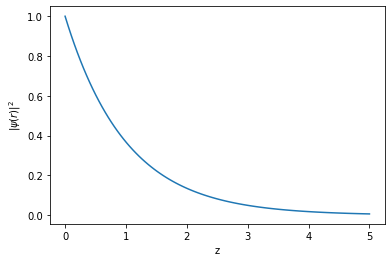

In [ ]:
import matplotlib.pyplot as plt
batch_psi_h = jax.vmap(psi_h, in_axes=(None, 1))

params = (1,)
n_batch = 100
r_batch = np.zeros((3, n_batch))
r_batch[2] = np.linspace(0,5,n_batch)
plt.plot(r_batch[2], batch_psi_h(params, r_batch))
plt.ylabel("$|\psi(r)|^2$")
plt.xlabel("z")


## Expectation values of observables
To understand the system, we need to evaluate expectation values, not just values at single points.

The Monte Carlo part of the name Variational Monte Carlo refers to how expecation values of operators are evaluated. Expectation values in configuration space are 3N-dimensional integrals, which suffer massively from the curse of dimensionality. Using a grid or quadrature method to evaluate the integrals scales with $d^{3N}$, where $d$ is the number of grid points per dimension. This quickly gets out of hand!

Instead, we use markov chain monte carlo sampling to evaluate the integrals, here exemplified with the energy expectation value,
\begin{align}
  \langle E\rangle_\theta
  &= \frac{\int \mathrm d \vec R\, \psi^*(\vec R; \theta)\hat H \psi(\vec R; \theta) } {\int
  \mathrm d \vec R\,|\psi(\vec R; \theta)|^2}
  = \int \mathrm d \vec R\, p(\vec R; \theta) E_L(\vec R; \theta) 
  \\&\approx
   \frac{1}{M} \sum_i E_L(\vec R^{(i)}; \theta).
\end{align}
We have defined the local energy as,
\begin{equation}
  E_L(\vec R; \theta) = \frac{\hat H\psi(\vec R; \theta)}{\psi(\vec
  R; \theta)},
\end{equation}
and the integral is approximated as a sum over configurations
$\{\vec R^{(i)}\}$ that are sampled from the well-known probability distribution
\begin{equation}
  p_\theta(\vec R^{(i)})
  = \frac{|\psi(\vec R^{(i)}; \theta)|^2 }{ \int \mathrm d \vec R\,|\psi(\vec R; \theta)|^2}
\end{equation}
The local energy is an important quantity, so we stop here for a moment to implement it.


## Problem 1
---
a) Implement a factory function which returns the local energy $E_L(\theta, \vec R)$ for a single electron in a hydrogen potential at the origin. We already supply the kinetic energy, but you will have to implement the potential energy. 

b) Given the hydrogen wavefunction above, evaluate the local energy at a random position. 

In [ ]:
def make_local_kinetic_energy(f):
  f_lapl = jax.hessian(f, argnums=1)
  def local_kinetic_energy(params, pos):
    return - 0.5 * jnp.trace(f_lapl(params, pos)) / f(params, pos)
  return local_kinetic_energy


# solution
def potential_energy(pos, charge):
  """For a single atom at the origin with variable charge"""
  pos = pos.reshape(-1, 3)
  ria_norms = jnp.linalg.norm(pos, axis=-1)
  i, j = jnp.triu_indices(pos.shape[0], k=1)
  rij_norms = jnp.linalg.norm(pos[i] - pos[j], axis=-1)

  v_ee = jnp.sum(1 / rij_norms)
  v_ea = -jnp.sum(charge / ria_norms)

  return v_ee + v_ea


# solution
def make_local_energy(
  f,
  charge=1.0,
):
  local_kinetic_energy = make_local_kinetic_energy(f)
  
  def local_energy(params, pos):
    kin_energy = local_kinetic_energy(params, pos)
    pot_energy = potential_energy(pos, charge=charge)
    return kin_energy + pot_energy
  return local_energy


pos = np.random.random((3,))
params = (1.0,)

local_energy = make_local_energy(psi_h, charge=1.0)
local_energy(params, pos)

DeviceArray(-0.49999997, dtype=float32)

You should have got the exact eigenvalue for the hydrogen atom, $-0.5E_h$. The variance in the local energy is zero when the wavefunction is an eigenfunction $\psi_n$ of the Hamiltonian with energy $E_n$, since we get $E_L = (1/\psi_n) \hat H \psi_n = E_n$ independent of configuration $\vec R$. In general, the variance of the local energy is a measure of how far we are from the exact ground state.

# Metropolis-Hastings

The next step is to sample $p(\vec R; \theta)$ using the MetropoliHastings algorithm, which you might or might not know, but it is a very simple algorithm so we'll present what you need here. It works by proposing moves $\vec R'$ locally from a 3N Gaussian distribution $N(\vec R, \sigma)$ with mean $\vec R$ and standard deviation $\sigma$. $\sigma$ is also called the step size. (The move proposal need not be Gaussian or even symmetric, but this choice works well for many cases.)

The probability of accepting a proposed move $\vec R \to \vec R'$ in the Metropolis algorithm (symmetric move proposal) is given by
\begin{equation}
  p(\vec R \to \vec R') = \text{min}\left(1, \frac{p(\vec R')}{p(\vec R)}\right) = \text{min}\left(1, \frac{|\psi(\vec R')|^2}{|\psi(\vec R)|^2}\right)
\end{equation}
If the wavefunction at the proposed configuration is larger than at the original position, then the proposal is always accepted. If not, then the acceptance is proportional to the ratio of the wavefunction. 
If you want more information on the Metropolis algorithm, the [Wikipedia article](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) is very good.

Observe that the wavefunction doesn't have to be normalized, since the normalization factor cancels out in the ratio. This is extremely useful!

_Important_: with local Metropolis steps, subsequent samples are highly correlated. Luckily, for this kind of VMC sampling is a lot cheaper than evaluating energies. We deal with the correlation problem by performing many configuration updates between each calculation of the observables. 


## Problem 2a
---
i) Implement Metropolis to equilibrate and produce a set of samples drawn from $|\psi|^2$. Fill in the factory function below.

ii) Reduce autocorrelation by running a for loop of $N_{substeps} = 50$ every time you perform Metropolis sampling.

<!-- Advanced: Add the for loop inside `metropolis(...)` to handle autocorrelation. $N_{substeps}$ should be supplied to `make_metropolis`. Note that jitting a pure python loop unrolls it, which can cause long compile times scaling with the number of substeps. This is bad, and you'll quickly run into problems.

Instead, do not use a regular python for loop, but a body_function (the body of the loop) and `jax.lax.fori_loop` [reference](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.fori_loop.html). Attempt at your own risk! -->

In [ ]:
### solution

# Contains both the normal and advanced implementations.

def make_metropolis(wavefunction, mcmc_steps=1, implementation='normal'):
  """Constructs a function which iterates the positions of MCMC walkers according
  to the Metropolis algorithm.

  Args:
      wavefunction: function of (params, pos)
  Returns:
      metropolis: function of (batch_pos, batch_prob, params, step_size, batch_keys).
  """

  # vmap over batch dimension.
  @functools.partial(jax.vmap, in_axes=(0,0,None,None,0))
  def metropolis(pos, prob, params, step_size, key):
    """Performs a Metropolis step. General for arbitrary number of electrons.

    Args:
      pos: nd array, shape (3N), current electron configurations, 
      prob: float, probability in current electron configurations, shape (,)
      params: pytree with wavefunction parameters
      step_size: float
      key: jax PRNG key. shape (batch size, *key_shape)
    Returns:
      batch_pos, batch_prob: updated values
      batch_accept_count: number of updates performed per walker
    """
    def body_fun(_, args):
      pos, prob, accept_count, key = args
      key, subkey = jax.random.split(key)
      pos_new = pos + step_size * jax.random.normal(
          subkey, shape=pos.shape
      )
      prob_new = wavefunction(params, pos_new)**2
  
      # Metropolis test
      key, subkey = jax.random.split(key)
      cond = jax.random.uniform(subkey) < prob_new / prob
      prob = jnp.where(cond, prob_new, prob)
      pos = jnp.where(cond, pos_new, pos)
  
      # count accepted proposals
      accept_count += jnp.sum(cond)
      return pos, prob, accept_count, key

    if implementation == 'normal':
      # body_fun is superfluous for the normal implementation 
      if mcmc_steps > 1:
        raise ValueError("mcmc_steps not used for normal implementation")
      pos, prob, accept_count, key  = body_fun(None, (pos, prob, 0, key))
      return pos, prob, accept_count
    # elif implementation == 'advanced_but_slow':
    #   # More steps per call but slower to compile
    #   accept_count = 0
    #   for i in range(mcmc_steps):
    #     pos, prob, accept_count, key = body_fun(i, (pos, prob, accept_count, key))
    # elif implementation == 'advanced':
    #   # More steps per call, fast compilation and backwards differentiable!
    #   pos, prob, accept_count, key = jax.lax.fori_loop(0, mcmc_steps, body_fun, (pos, prob, 0, key))
    #   return pos, prob, accept_count
    else:
      raise ValueError(f"Implementation {repr(implementation)} not implemented.")
  return metropolis



## Problem 2b:
---
Start with an initial distribution drawn from a Gaussian from the code below. Produce a set of samples from `psi_h` that are drawn with the desired probability distribution. Verify your sampling algorithm by histogramming $r = |\vec r|$ and comparing to the the radial distribution function supplied below. It can be illuminating to compare the histograms from the initial and final distributions, see the code below for an example of how to.

Hint: whilst not critical in this case, a good rule of thumb is to aim for an acceptance rate of around 50%.

In [ ]:
def init_electrons_gaussian(key, batch_size: int,  nelec: int, init_width: float=0.5):
  """Initialises electron positions by sampling from a Gaussian distribution.

  Args:
    key: JAX PRNG state.
    batch_size: number of walkers to create.
    nelec: number of electrons in the system.
    init_width: scale of initial Gaussian distribution.
  """ 
  ndim = 3
  init_pos = init_width * jax.random.normal(
    subkey, shape=(batch_size, nelec * ndim)
  )
  return init_pos

@jax.jit
def batch_split(key):
  """Like jax.random.split, but returns one subkey per batch element.
  
  Returns: 
    key: jax.PRNGkey, shape (2,)
    batch_keys: jax.PRNGkeys, shape (batch_size, 2)
  """
  key, *batch_keys = jax.random.split(key, num=batch_size+1)
  return key, jnp.asarray(batch_keys)

In [ ]:
### solution

import tqdm.notebook as tqdm

# Affects acceptance rate and quality of sampling. 
# Golden rule: keep acceptance rate around 50%.
step_size = 0.6
batch_size = 4096
params = (1.0,)
mcmc_steps = 100
num_substeps = 1

key = jax.random.PRNGKey(seed=42)

metropolis = jax.jit(make_metropolis(psi_h))

# initialize electrons
key, subkey = jax.random.split(key)
init_pos = init_electrons_gaussian(subkey, batch_size, nelec=1, init_width=0.5)
prob = jax.vmap(psi_h, (None, 0))(params, init_pos) ** 2

pos = init_pos
for i in tqdm.tqdm(range(mcmc_steps)):
  key, batch_keys = batch_split(key)
  pos, prob, accept_count = metropolis(pos, prob, params, step_size, batch_keys)

pmove = np.average(accept_count/num_substeps)
print(f"pmove = {pmove:.2f}")

### plot distributions

In [ ]:
# Plot histograms
r_bins = np.linspace(0, 6.5, 100)

def plot_h_rdf(params, r_bins):
  """Plots the radial distribution function for the hydrogen wavefunction"""
  # array of positions along the z axis
  pos = jnp.zeros((r_bins.size, 3)).at[:,2].set(r_bins)
  prob = jax.vmap(psi_h, (None, 0))(params, pos)**2
  # normalization constant and volume factor is (4/a**3) [remember psi_h is
  # unnormalised but the rdf expects normalised wavefunctions]
  rdf = (4/params[0]**3) * r_bins**2 * prob
  plt.plot(r_bins, rdf, label='RDF', c='k')

def hist_radial_distribution(pos, t=None):
  r = np.linalg.norm(pos, axis=-1).ravel()
  plt.hist(r, bins=r_bins, histtype='step', density=True, label=f't={t}');

plot_h_rdf(params, r_bins)
hist_radial_distribution(init_pos, t=0)
hist_radial_distribution(pos, t='final')

plt.legend()
plt.xlabel("radial distance $r$")
plt.ylabel("wavefunction");

We now move on to two-electron systems for a slightly more challenging problem. Delete the old one-electron functions just to be safe.

In [ ]:
# make sure to get rid of everything related to hydrogen
del local_energy, pos, prob, metropolis, step_size, batch_size, params, mcmc_steps, pmove

## Problem 3
---
Modify the energy evaluation code to handle arbitrary number of electrons, where the electron positions are supplied as a 3N array.

Hint 1: use `jnp.reshape(pos, (-1, 3))` to obtain an array of $N\times3$ and then apply operations along the first axis, corresponding to electron positions.

Hint 2: broadcasting in JAX works similarly to broadcasting in numpy.

In [ ]:
### Solution:
# See solution of problem 1, which already handles arbitrary numbers of electrons

## Problem 4
---
Similarly modify the Metropolis-Hastings code to handle an arbitrary number of electrons. You can either attempt a single $N$ electron move or $N$ single-electron moves, each with their own accept-reject step. For small systems, this choice doesn't have a strong impact on efficiency ([Lee *et al.*](https://doi.org/10.1103/PhysRevE.83.066706)).


In [ ]:
### Solution
# See solution of problem 2, which already handles arbitrary numbers of electrons

# Gradient of the energy

We can efficiently compute the gradient of the energy using:

$$
\nabla_\theta\mathcal{L} = 2 \mathbb{E}_{p(\vec R)}\left[\left(E_L - \mathbb{E}_{p(\vec R)}[E_L]\right)\nabla_\theta \log|\Psi_\theta|\right]
$$

In particular, this means we don't have to compute derivatives of the Hamiltonian, and so do not require third derivatives of the wavefunction! Code for doing so (adapted from the [FermiNet codebase](https://github.com/deepmind/ferminet)) is below.

In [ ]:
def make_loss(network, local_energy):
  """Copied from Ferminet.

  Creates the loss function, including custom gradients.

  Args:
  network: function, signature (params, data), which evaluates wavefunction
    at a single MCMC configuration given the network parameters.
  Returns:
    total_energy: function which evaluates the both the loss as the mean of the 
      local_energies, and the local energies. With custom gradients, accounting 
      for derivatives in the probability distribution.
  """
  batch_local_energy = jax.vmap(local_energy, in_axes=(None, 0), out_axes=0)
  # FermiNet is defined in terms of the logarithm of the network, which is 
  # better for numerical stability and also makes some expressions neater.
  log_network = lambda params, pos: jnp.log(jnp.abs(network(params, pos)))
  batch_network = jax.vmap(log_network, in_axes=(None, 0), out_axes=0)

  @jax.custom_jvp
  def total_energy(params, data):
    e_l = batch_local_energy(params, data)
    loss = jnp.mean(e_l)
    return loss, e_l

  @total_energy.defjvp
  def total_energy_jvp(primals, tangents):
    """Custom Jacobian-vector product for unbiased local energy gradients."""
    params, data = primals
    loss, local_energy = total_energy(params, data)
    diff = local_energy - loss

    # We will walk through this section in the practical session
    psi_primal, psi_tangent = jax.jvp(batch_network, primals, tangents)
    primals_out = loss, local_energy
    batch_size = jnp.shape(local_energy)[0]
    tangents_out = (jnp.dot(psi_tangent, diff) / batch_size, local_energy)
    return primals_out, tangents_out
  return total_energy

## Problem 5
---
Given the 4 parameter helium wavefunction (in log space), equilibrate MCMC samples, evaluate the energy and gradient.

A simple [four-parameter helium wavefunction](https://opencommons.uconn.edu/chem_educ/30/) is:
\begin{equation}
 \psi_{He}(\vec r_1, \vec r_2; \theta:=\{a, b, c, d\}) = e^{-2s}(1+\frac{u}{2}e^{au})(1 + bsu + ct^2 + du^2) 
\end{equation}
where $s=r_1 + r_2$, $u=r_1 - r_2$, and $t=|\vec r_1 - \vec r_2|$.
The wavefunction is defined in JAX below.

Equilibrate MCMC samples, and hence estimate the energy and gradient of the energy. Compare to the exact ground state energy of helium (-2.903724377 Ha).


In [ ]:
def psi_he_hylleraas(params, pos):
  """Evaluates a two-electron wavefunction with four parameters based on the 
  Hylleraas parametrization of the helium atom.

  C.W. David found parameters a=-1.013, b=0.2119, c=0.1409, d=-0.003 via
  independent line searches and hence obtained an energy of -2.901188.
  
  Arguments:
    params: tuple (a,) containing the length scale a
    r: nd array like, shape (3,).
  Outputs
  """
  if pos.shape != (6,): raise ValueError("positions have wrong shape, should be 3,")
  a, b, c, d = params
  r1, r2 = jnp.linalg.norm(pos.reshape(2, 3), axis=1)
  r12 = jnp.linalg.norm(pos[:3] - pos[3:])

  s = r1 + r2
  t = r1 - r2
  u = r12

  f = jnp.exp(-2 * s)
  g = 1 + b * s * u + c * t ** 2 + d * u ** 2
  h = 1 + 0.5 * u * jnp.exp(a * u)
  return f * g * h


def init_hylleraas_params():
  """Returns an arbitrary (i.e. quite bad) set of initial parameters for the 
  hylleraas wavefunction."""
  return (1.0,1.0,1.0,1.0)


### Solution

In [ ]:
local_energy = make_local_energy(psi_he_hylleraas, charge=2.0)
vmap_local_energy = jax.vmap(local_energy, (None, 0))
total_energy = make_loss(psi_he_hylleraas, local_energy)
loss_and_grad = jax.jit(jax.value_and_grad(total_energy, argnums=0, has_aux=True))

In [ ]:
batch_size = 4096
mcmc_steps = 50
step_size = 0.4

# initialize electrons
key, subkey = jax.random.split(key)
init_pos = init_electrons_gaussian(subkey, batch_size, nelec=2, init_width=2)
params = init_hylleraas_params()
prob = jax.vmap(psi_he_hylleraas, (None, 0))(params, init_pos) ** 2

# Run mcmc to equilibrate
pos = init_pos
key, subkey = jax.random.split(key)

(loss, energies), gradients = loss_and_grad(params, pos)
# the energy can be below the exact when the walkers are not properly distributed.
print(f"Poorly sampled loss: {loss:.2f} E_h")

metropolis = jax.jit(make_metropolis(psi_he_hylleraas))
for i in tqdm.tqdm(range(mcmc_steps)):
  key, batch_keys = batch_split(key)
  pos, prob, accept_count = metropolis(pos, prob, params, step_size, batch_keys)
(loss, energies), gradients = loss_and_grad(params, pos)

print(f"Better sampled loss: {loss:.2f} E_h")
print("Params  : " + ", ".join(f"{p:.3f}" for p in params))
print("Gradients: " + ", ".join(f"{g:.3f}" for g in gradients))

Poorly sampled loss: -3.15 E_h


  0%|          | 0/50 [00:00<?, ?it/s]

Better sampled loss: -1.33 E_h
Params  : 1.000, 1.000, 1.000, 1.000
Gradients: 0.633, 0.015, -0.040, 0.032


# Updating parameters

For small and simple systems, a simple first order optimization method such as ADAM is sufficient. The [`optax`](https://github.com/deepmind/optax) library provides many optimizers and useful utilities for optimization.

We can create and initialise the optimizer with the following code:

In [ ]:
import optax

params = init_hylleraas_params()
init_learning_rate = 2e-2
optimizer = optax.adam(init_learning_rate)
opt_state = optimizer.init(params)

Other optimizers in `optax` share the same API: the `init` method initialises the optimizer and takes an arbitary structure (a "PyTree") of trainable parameters. This conveniently enables parameters to be organised as nested dictionaries, for example.

Returning to our Hylleraas Helium wavefunction, we can evaluate the required updates to the parameters using `optimizer.update`:

In [ ]:
# where gradients is the gradients of the energy with respect to the parameters,
# as evaluated in problem 5.
updates, opt_state = optimizer.update(gradients, opt_state, params)

and calculate the new parameters using `optax.apply_updates`:

In [ ]:
new_params = optax.apply_updates(params, updates)

## Problem 6
---
Write a training loop for the Hylleraas Helium wavefunction which for each iteration:

1. runs Metropolis-Hastings to draw samples according to $\Psi^2$
1. evaluates the energy and gradients
1. updates the parameters

Monitor the energy each iteration of the training loop to study convergence. Do you find parameters giving a lower energy ('better') wavefunction than the published values?

Tip: Remember to equilibrate the MCMC samples after initialising them from a Gaussian distribution, as well as between each parameter update!

### Solution: training loop 

In [ ]:
params = (1.0, 1.0, 1.0, 1.0)
num_substeps = 100
step_size = 0.7

# equilibrate to the initial parameters before starting training
for i in tqdm.tqdm(range(100)):
  key, batch_keys = batch_split(key)
  pos, prob, accept_count = metropolis(pos, prob, params, step_size, batch_keys)


# equilibrate to new parameter
iterations = 200
losses = []
stds = []
mcmc_steps = 100
for t in tqdm.tqdm(range(iterations)):
  for i in range(mcmc_steps):
    key, batch_keys = batch_split(key)
    pos, prob, accept_count = metropolis(pos, prob, params, step_size, batch_keys)

  (loss, energies), gradients = loss_and_grad(params, pos)
  grad = jax.tree_map(np.mean, gradients)
  
  updates, opt_state = optimizer.update(grad, opt_state, params)
  params = optax.apply_updates(params, updates)

  losses.append(loss)
  # stds.append(np.std(energies))

params

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

(DeviceArray(-0.25170693, dtype=float32),
 DeviceArray(0.19370922, dtype=float32),
 DeviceArray(0.11024828, dtype=float32),
 DeviceArray(-0.11268681, dtype=float32))

### Solution: Plot energy convergence


-2.901219


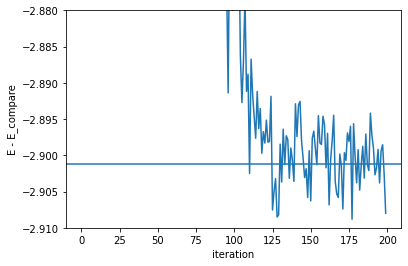

In [ ]:
e_compare = -2.90118
plt.plot(np.arange(iterations), np.array(losses))
plt.axhline(e_compare)
plt.xlabel("iteration")
plt.ylabel("E - E_compare")
plt.ylim(-2.91, -2.88)
print(np.mean(losses[-10:]))

### solution, inference

Sample more energies for a better estimate of the loss of the optimized wavefunction

In [ ]:
inference_losses = []
for t in tqdm.tqdm(range(iterations)):
  for i in range(mcmc_steps):
    key, batch_keys = batch_split(key)
    pos, prob, accept_count = metropolis(pos, prob, params, step_size, batch_keys)

  (loss, energies), gradients = loss_and_grad(params, pos)
  inference_losses.append(loss)
  
np.mean(inference_losses)

  0%|          | 0/200 [00:00<?, ?it/s]

-2.899961

# Simple MLP for a 2e system


Now we have learned almost everything we need: we can draw samples using Metropolis-Hastings, evaluate the energy and gradient using importance sampling, and update the parameters of a wavefunction and repeat!

Now let's move on to using a neural network for the wavefunction. Let's continue with the helium atom. As the ground state is a singlet and helium is a two electron system, the spatial wavefunction must be symmetric (the antisymmetry comes from the spin part of the wavefunction). We can hence learn the helium ground state wavefunction using just a multi-layer perceptron (MLP).

In [ ]:
# make sure to get rid of everything related to the hylleraas wavefunction

del total_energy, loss_and_grad, local_energy, pos, prob, metropolis, step_size
del batch_size, params, mcmc_steps, losses

## Problem 7:

Write a network which uses a simple envelope function multiplied by the MLP output, given by
\begin{equation}
\psi_{MLP}(\vec r_1, \vec r_2; \theta) = e^{-Z(r_1 + r_2)} \Phi(\vec f(\vec r_1, \vec r_2); \theta)
\end{equation}
Here $Z=2$, and the envelope ensures the wavefunction obeys the open boundary conditions ($\vec r \to \infty \Rightarrow \psi \to 0$). The MLP is $\Phi(\vec f(\vec R); \theta)$, where $f$ constructs the input features to the network. Optimize the network using ADAM and monitor energy convergence.

Try using electron positions and distances as features, $\vec f(\vec r_1, \vec r_2) = \{\vec r_1, \vec r_2, r_1, r_2\}$, then try adding the electron-electron distances $r_{12} = |\vec r_1 - \vec r_2|$ as well. 

Some points:
  - Don't worry if you can't beat the 4-parameter wavefunction, it is possible but requires hyperparameter tuning. The Hylleraas wavefunction parametrization is in fact quite good! 
  - Monitor pmove! Weird behaviour in the energy might easily come from pmove going to zero. 
  - Make sure enough mcmc steps are performed after initializing the electrons.
  - Make sure enough mcmc steps are performed between each energy evaluation.

In [ ]:
import chex
from typing import Dict, List
LayerParams = Dict[str, jnp.ndarray]
NetworkParams = List[LayerParams]

# For first order optimization, parameter initialization matters
def layer_params(key: chex.PRNGKey, m: int, n: int) -> LayerParams:
  """Glorot initialization, suitable for the tanh activation function."""
  bound = np.sqrt(6/(m + n)) 
  w_key, b_key = jax.random.split(key)
  return dict(w=jax.random.uniform(w_key, shape = (n,m), minval=-bound, maxval=bound),
             b=jnp.zeros(n))


def init_mlp_params(key, hidden_layer_sizes: List[int], input_size: int =3) -> NetworkParams:
  """
  Args:
    key: jax.PRNGkey
    hidden_layer_sizes: list of the sizes of each hidden layer.
  """
  sizes = [input_size] + list(hidden_layer_sizes) + [1]
  # hidden layers
  params = []
  for m, n in zip(sizes[:-1], sizes[1:]):
    key, subkey = jax.random.split(key)
    params.append(layer_params(subkey, m, n))
  return params


def mlp_forward(inputs: jnp.ndarray, params: NetworkParams) -> jnp.ndarray:
  """Forward pass of the MLP.
  
  Args:
    inputs: input features
    params: list of dictionaries with the network parameters. 
  """
  a = inputs

  for layer in params[:-1]:
    outputs = jnp.dot(layer['w'], a) + layer['b']
    a = jnp.tanh(outputs)

  final_layer = params[-1]
  return jnp.squeeze(jnp.dot(final_layer['w'], a))


### solution

In [ ]:
# solution
def cusp(pos_norms: jnp.ndarray, Z: float):
    return jnp.exp(-Z * jnp.sum(pos_norms))


# solution
def make_mlp_wavefunction(hidden_layer_sizes: List[int], Z: float=2.0, ) -> Callable:
  def mlp_wavefunction(params: NetworkParams, pos: jnp.ndarray):
    """
    simple neural net wavefunction for two electrons in a central symmetric 
    potential, as a function of vec r1, vec r2, r1=|vec r1|, r2=|vec r2| and r12=|vec r1-vec r2|.
    
    pos: array like, positions of the two particles.
    params: list of dictionary with array weights, list length and array shapes 
        determines network architecture. 
    """
    r1, r2 = jnp.linalg.norm(pos.reshape(2, 3), axis=1)
    r12 = jnp.linalg.norm(pos[:3] - pos[3:])
  
    return cusp(r1+r2, Z=Z) * jnp.squeeze(
        mlp_forward(jnp.concatenate([pos, r1[None], r2[None], r12[None]]), params))
 
  ndim = 3
  input_size = 9
  network_init = functools.partial(init_mlp_params, 
                                   hidden_layer_sizes=hidden_layer_sizes, 
                                   input_size=input_size)
  return mlp_wavefunction, network_init

In [ ]:
# solution, initialize network, metropolis, loss function and walkers
from pprint import pprint
hidden_layer_sizes = (32,) * 3

Z = 2.0
network, network_init = make_mlp_wavefunction(hidden_layer_sizes, Z=Z)

init_width = 0.4
step_size = 0.3

metropolis = jax.jit(make_metropolis(wavefunction=network))
local_energy = make_local_energy(network, charge=Z)
total_energy = make_loss(network, local_energy)
loss_and_grad = jax.jit(jax.value_and_grad(total_energy, argnums=0, has_aux=True))

seed = int(1e6*time.time())
key = jax.random.PRNGKey(seed)
key, subkey=jax.random.split(key)
pos = init_electrons_gaussian(subkey, init_width=0.4, batch_size=4096, nelec=2)

params = network_init(key)
prob = jax.vmap(network, (None,0))(params, pos) ** 2

print("Network parameter shapes:")
pprint(jax.tree_map(jnp.shape, params))

mcmc_steps = 200

print("Start thermalize")
for i in tqdm.tqdm(range(mcmc_steps)):
  key, batch_keys = batch_split(key)
  pos, prob, accept_count = metropolis(pos, prob, params, step_size, batch_keys)
(loss, energies), gradient = loss_and_grad(params, pos)
print(f"Initial loss:{loss:.2f}")
print(f"Initial pmove:{np.mean(accept_count):.2f}")

Network parameter shapes:
[{'b': (32,), 'w': (32, 9)},
 {'b': (32,), 'w': (32, 32)},
 {'b': (32,), 'w': (32, 32)},
 {'b': (1,), 'w': (1, 32)}]
Start thermalize


  0%|          | 0/200 [00:00<?, ?it/s]

Initial loss:-2.08
Initial pmove:0.44


In [ ]:
# solution, initialize optimizer
initial_learning_rate = 3e-2
params = network_init(key)
optimizer = optax.adam(initial_learning_rate)
opt_state = optimizer.init(params)

In [ ]:
# solution, optimize
iterations = 500

losses = []
pmoves = []
print("Start optimize")
pbar = tqdm.tqdm(range(iterations))
for t in pbar:
  for i in range(mcmc_steps):
    key, batch_keys = batch_split(key)
    pos, prob, accept_count = metropolis(pos, prob, params, step_size, batch_keys)

  (loss, energies), gradient = loss_and_grad(params, pos)
  grad = jax.tree_map(functools.partial(np.mean, axis=0), gradient)
  updates, opt_state = optimizer.update(grad, opt_state, params)
  params = optax.apply_updates(params, updates)

  losses.append(loss)
  pmoves.append(np.mean(accept_count))
  pbar.set_description(f"Loss: {loss:.3f}")

Start optimize


  0%|          | 0/500 [00:00<?, ?it/s]

-2.895207


Text(0.5, 0, 'iteration')

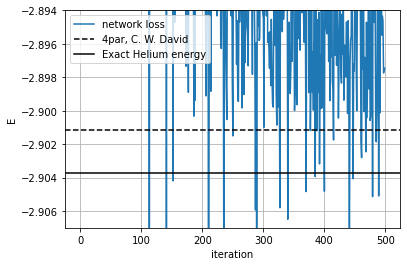

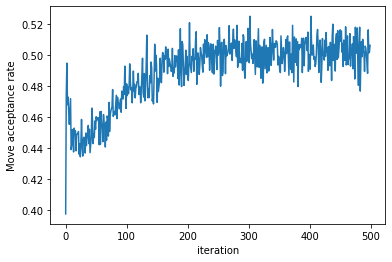

In [ ]:
# plotting code

e_exact = -2.903724377
losses_filtered = tenperc_medfilt(losses)
plt.plot(losses, label='network loss')
plt.axhline(e_compare, c='k', linestyle='--', label='4par, C. W. David')
plt.axhline(e_exact, c='k', label='Exact Helium energy')
plt.ylim(-2.907, -2.894)

plt.legend()
plt.xlabel("iteration")
plt.ylabel("E")
plt.grid()
plt.figure()
# pmove typically varies as the wavefunction varies, but should land around 50% 
# with this step size of 0.3
plt.plot(pmoves)
plt.ylabel("Move acceptance rate")
plt.xlabel("iteration")
print(np.mean(losses[-200:]))

# Things we did not do.
The network at hand should have sufficient capacity for the Helium atom. Here are some approaches that we could have taken to help convergence:
  - gradient clipping, clipping outliers in the gradient of the log wavefunction, which can blow up near nodes of the wavefunction, causing unstable optimization.
  - increase size of network (can help up to a point)
  - second order optimization methods based on natural gradient descent such as KFAC, conjugate gradient etc. to help converge faster and more stably

# Bonus: Implementing a minimal FermiNet

Note: in the following $[a,b]$ denotes vector concatenation of $a$ and $b$.

FermiNet consists of repeating layers of permutation-equivariant blocks and non-linear transformations:

$$
f^l_i = \left[h^l_i, \sum_{j,\sigma_j\in\uparrow} h^l_j, \sum_{j,\sigma_j\in\downarrow} h^l_j\right] \\
h^l_i = \tanh\left(V^l f^{l-1} + g^l\right) + h^{l-1}_i
$$

where the restrictions over the summations in $f^l_i$ indicate we average over the latent vectors associated with $\uparrow$ electrons separately from those associated with $\downarrow$ electrons, and

$$
h^0_i = [\vec{r}_i, \vec{r}_i]
$$

After $L$ layers, we need to produce $N_\uparrow$ orbitals from each latent vector associated with a $\uparrow$ electron and similarly for $\downarrow$ electrons:

$$
\phi_i(\vec r_j) = (w_i h_j + g_i) . \sum_I \pi_{iI} \exp(-\Sigma_{iI} r_{iI})
$$

where the summation term gives the envelope function used to ensure the boundary conditions are satisfied. We can hence evaluate the spin-factored wavefunction:

$$
\Psi = \det[\phi_i^\uparrow] \det[\phi_j^\downarrow]
$$

Implement and train this model on a small atom such as Lithium or Beryllium.

## Bonus Bonuses

### Two electron streams

We can extend the minimal FermiNet model to include two-electron features explicitly using a two electron functions, which we model with a separate MLP:

$$
h^0_{ij} = [\vec{r}_{ij}, r_{ij}] \\
h^l{ij} = \tanh(W^l h^{l-1}_{ij} + c^l) + h^{l-1}_{ij}
$$

The activation to the $l$-th layer of the one-electron then becomes:

$$
f_i^l = \left[h^l_i, \sum_{j,\sigma_j\in\uparrow} h^l_j, \sum_{j,\sigma_j\in\downarrow} h^l_j, \sum_{ij,\sigma_j=\sigma_j} h^l_{ij}, \sum_{ij,\sigma_j=\sigma_j} h^l_{ij} \right]
$$

### Determinant expansions

We can create a linear combination of $N_k$ FermiNet determinants by producing $N_k$ more orbitals in the orbital shaping linear transformation. Extend your model to handle multiple determinants.

Note: it might be numerically more stable to work in the log domain here!

## coupled cluster
If you do well with the MLP or do the bonus questions, you might want a better reference value. The code snippet below evaluates the Coupled Cluster Singles Doubles (CCSD) Helium energy for a fairly large basis of Gaussian Type Orbitals (GTOs). CCSD contains all excitations up to double-excitations, so it is exact (in the given basis set) for two particles.

In [ ]:
import pyscf
import pyscf.cc
m = pyscf.gto.mole.M(atom = "He 0 0 0", basis="ccpv5z")
m = m.build()

mf = pyscf.scf.RHF(m)
mf.kernel()
mycc = pyscf.cc.CCSD(mf).run()
e_cc = mycc.e_tot

converged SCF energy = -2.86162483458191
E(CCSD) = -2.903151880049923  E_corr = -0.04152704546801235
